In [1]:
import numpy as np
import pandas as pd
from matplotlib import font_manager as fm, pyplot as plt, gridspec as gs, rcParams, patches
helv=fm.FontProperties(fname='helvetica.ttf')
plt.style.use('seaborn-colorblind')
from scipy.stats import *
from statsmodels.api import OLS,Logit
from sklearn.preprocessing import normalize
from scipy.spatial.distance import euclidean,mahalanobis
from sklearn.cluster import KMeans

In [2]:
dataset='all_beta_center_p1e-06_20200506_500PCs'
npc=300 

# phenotypes to analyze
phe_codes=['INI21001','HC326','HC328'] 

# for regression models
covariate=['age','sex']+['PC'+str(i+1) for i in range(4)]

# load data
z=np.load('/oak/stanford/groups/mrivas/projects/degas-risk/datasets/train/v2/tsvd/'+
           dataset+'.npz', allow_pickle = True)
scores=pd.read_csv('/oak/stanford/groups/mrivas/projects/degas-risk/scorefiles/v2/'+
                    dataset+'.sscore',
                   index_col='#IID',sep = "\t")
phenos=pd.read_csv('/oak/stanford/groups/mrivas/projects/degas-risk/master.20200420.phe',
                     usecols=['IID']+phe_codes+covariate,
                     index_col='IID',
                     na_values=-9, sep = "\t")

# analysis populations -- names are misleading
val=set(pd.read_table('/oak/stanford/groups/mrivas/projects/degas-risk/population-split/'+
                      'ukb24983_white_british_test.phe').iloc[:,0].tolist())
train=set(pd.read_table('/oak/stanford/groups/mrivas/projects/degas-risk/population-split/'+
                        'ukb24983_white_british_valid.phe').iloc[:,0].tolist())
# phenotype names
with open('../../ukbb-tools/05_gbe/icdinfo.txt','r') as f:
    code_to_name = {line.split()[0]:line.split()[2].replace('_',' ').split('(')[0].capitalize() for line in f}

# program some special cases
code_to_name['INI21001'] = 'BMI'
code_to_name['HC326'] = 'MI'

BMI
PC2: 62.0%, PC13: 2.3%, PC206: 1.7%, PC205: 1.3%, PC18: 1.3%
PC1: 58.7%, PC18: 6.9%, PC9: 4.0%, PC208: 2.4%, PC218: 1.3%
PC6: 41.0%, PC18: 12.9%, PC218: 3.2%, PC1: 2.7%, PC9: 2.2%
MI
PC12: 32.0%, PC16: 8.6%, PC13: 7.9%, PC32: 6.0%, PC30: 3.5%
PC16: 40.2%, PC30: 6.8%, PC32: 6.7%, PC202: 3.4%, PC44: 2.2%
PC11: 26.6%, PC9: 7.7%, PC32: 6.1%, PC30: 5.0%, PC16: 4.1%
Gout
PC1: 6.0%, PC227: 5.5%, PC2: 4.4%, PC76: 3.9%, PC222: 3.8%
PC7: 54.3%, PC227: 1.7%, PC20: 1.6%, PC1: 1.5%, PC75: 1.5%


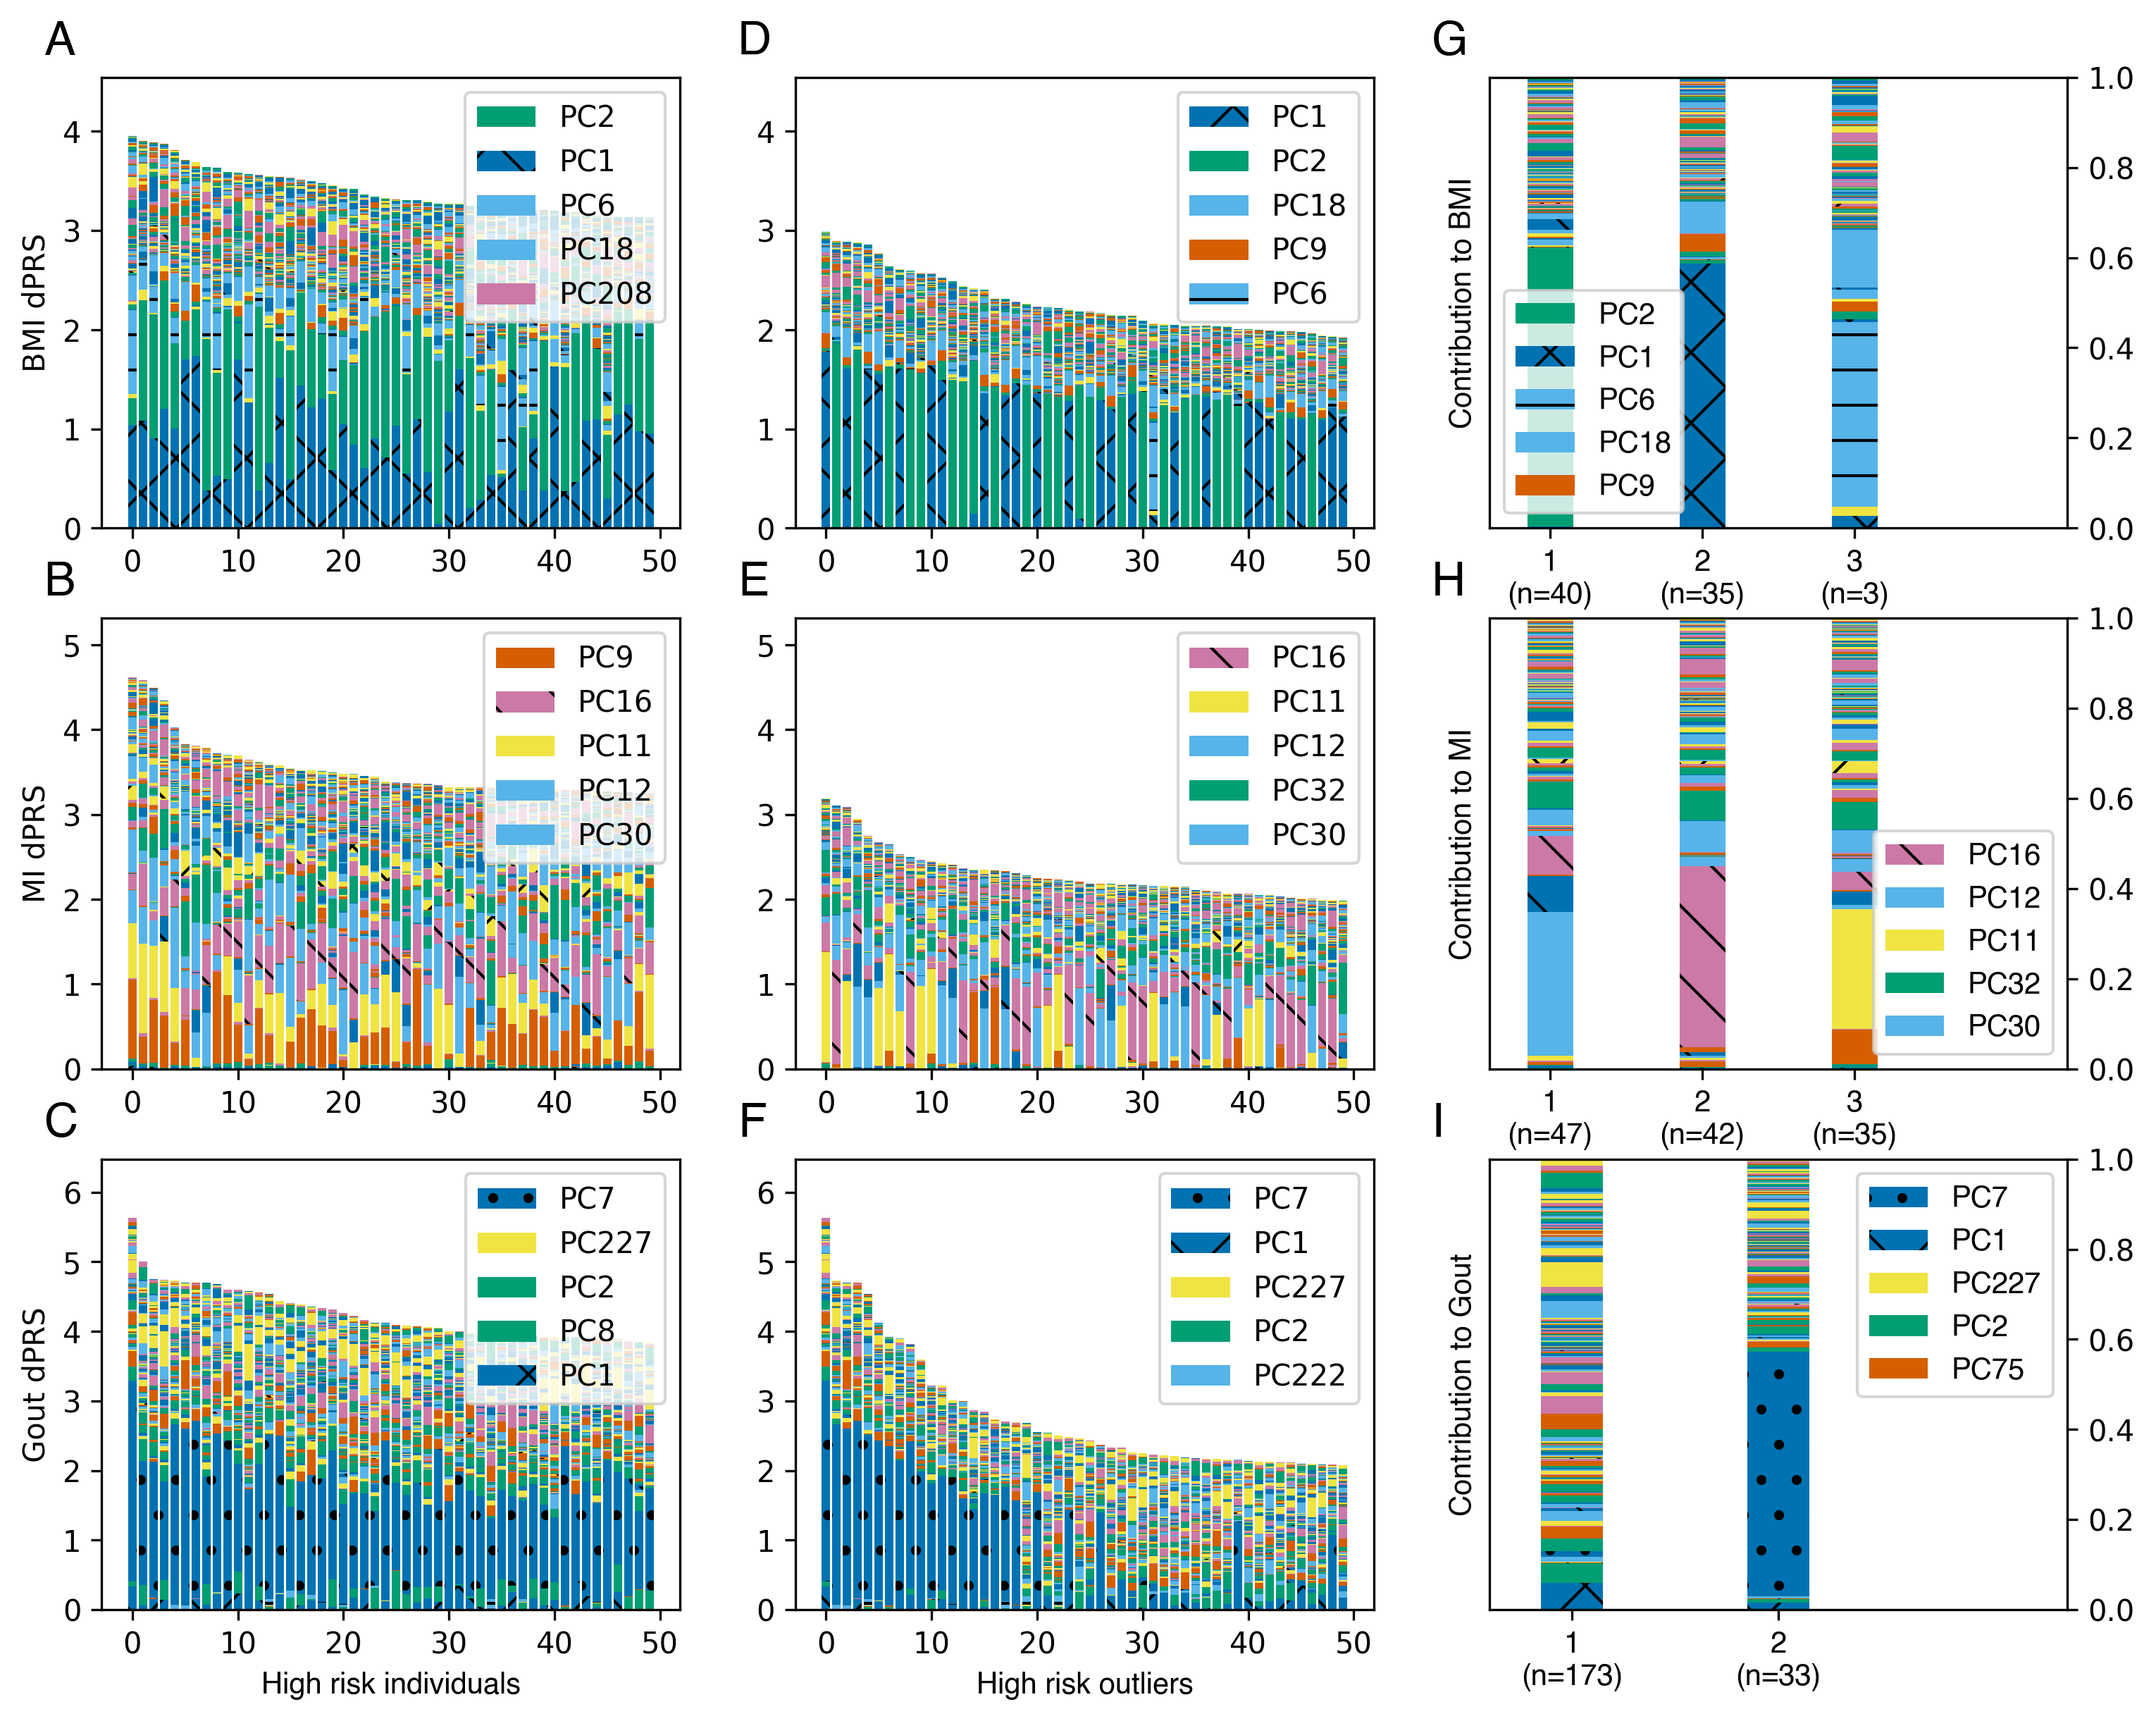

In [7]:
# setup
width = 3
plots = [None for _ in range(width * len(phe_codes))]
patterns = ('.', 'x', '-', '+', '\\')
pcps = {1:'x', 3:'+', 6:'-', 7:'.', 13:'\\', 16:'\\', 169:'.', # BMI
        41:'x', 133:'+', 135:'-', 142:'.', 147:'\\', # MI
        89:'+', 94:'x', 108:'-', 109:'x', 114:'.', 117:'\\'} # gout
plt.close('all'); plt.clf()
fig = plt.figure(figsize=(5*width/1.25, 4*len(phe_codes)/1.25), dpi=300)
score_pcs=['SCORE{}_SUM'.format(pc+1) for pc in range(npc)]
profl_pcs=['PROF_PC{}'.format(pc+1) for pc in range(npc)]

# loop over traits
for ix,phe_code in enumerate(phe_codes):
    print(code_to_name[phe_code])
    for ix2 in range(width):
        plots[(width*ix)+ix2]=plt.subplot(len(phe_codes), width, width*ix + ix2 + 1)
    # scores and phenotypes
    phe_name=code_to_name[phe_code]
    df=phenos.loc[val,[phe_code]+covariate].dropna().merge(scores, left_index=True, right_index=True)
    dg=phenos.loc[train,[phe_code]+covariate].dropna().merge(scores, left_index=True, right_index=True)
    n=df.shape[0]
    weights=z['V'][np.where(z['label_phe_code'] == phe_code),:].flatten()[:npc]
    df['dPRS']=zscore(df[score_pcs].dot(weights))
    dg['dPRS']=zscore(dg[score_pcs].dot(weights))
    df['1']=1
    dg['1']=1
    
    # filter to cases for clustering binary traits
    if len(df[phe_code].value_counts()) == 2:
        is_bin=True
        df[phe_code]-=1
        dg[phe_code]-=1
        regress=Logit
        # df=df[df[phe_code]==2]
    else:
        is_bin=False
        regress=OLS
    
    # center dPRS, sort individuals
    df['SCORE']=zscore(df['dPRS'])
    df.sort_values(by='SCORE',ascending=False,inplace=True)  
    
    # do painting
    n=df.shape[0]
    for pc in range(npc):
        df[profl_pcs[pc]]=(df[score_pcs[pc]] * weights[pc] * df['SCORE']).clip(lower=0)
    df[profl_pcs] = normalize(df[profl_pcs], norm='l1')

    # (A): paint o=50 highest risk individuals
    o=50
    top5pc=np.argsort(df.iloc[:50,:]['SCORE'].dot(df.iloc[:50,:][profl_pcs])[:npc])[-5:][::-1]
    pc_plots=[]
    for pc in range(npc):
        pp=plots[(width*ix)].bar(np.arange(o), 
                                 df.iloc[:o,:][profl_pcs[pc]] * df.iloc[:o,:]['SCORE'],
                                 bottom=np.array(df.iloc[:o,:][profl_pcs[:pc]].sum(axis=1) * df.iloc[:o,:]['SCORE']),
                                 hatch=pcps[pc+1] if pc+1 in pcps else None
                                 )
        pc_plots.append(pp)
    # axis labels and such
    plots[(width*ix)].set_ylim(0, 1.15*df['SCORE'].max())
    plots[(width*ix)].set_ylabel(phe_name+' dPRS')
    plots[(width*ix)].legend([pc_plots[i] for i in top5pc], ['PC'+str(i+1) for i in top5pc], loc=1)
    
    # identify high risk outliers
    fp=0.05
    drp_centroid=df.iloc[:int(fp * df.shape[0]),:][profl_pcs].mean()
    df['mahal']=df.iloc[:int(fp * df.shape[0]),:][profl_pcs].apply(lambda x: euclidean(x, drp_centroid), axis=1)
    #VI=np.linalg.inv(df.iloc[:int(fp * df.shape[0]),:][profl_pcs].cov().values + 1e-12*np.eye(300))
    #df['mahal']=df.iloc[:int(fp * df.shape[0]),:][profl_pcs].apply(lambda x: mahalanobis(x, drp_centroid, VI), axis=1)
    m_star=df.iloc[:int(fp * df.shape[0]),:]['mahal'].mean() + 2*df.iloc[:int(fp * df.shape[0]),:]['mahal'].std()
    outliers=df.iloc[:int(fp * df.shape[0]),:].query('mahal > @m_star').index
    
    # (B): paint o=50 high risk outliers
    top5pc=np.argsort(df.loc[outliers,'SCORE'].dot(df.loc[outliers,profl_pcs])[:npc])[-5:][::-1]
    pc_plots=[]
    for pc in range(npc):
        pp=plots[(width*ix)+1].bar(np.arange(o), 
                                   df.loc[outliers[:o],profl_pcs[pc]] * df.loc[outliers[:o],'SCORE'],
                                   bottom=np.array(df.loc[outliers[:o],profl_pcs[:pc]].sum(axis=1) * 
                                                   df.loc[outliers[:o],'SCORE']),
                                   hatch=pcps[pc+1] if pc+1 in pcps else None
                                   )
        pc_plots.append(pp)
    # axis labels and such
    plots[(width*ix)+1].set_ylim(0, 1.15*df['SCORE'].max())
    plots[(width*ix)+1].legend([pc_plots[i] for i in top5pc], ['PC'+str(i+1) for i in top5pc])
    
    # perform clustering
    k=1
    cluster = KMeans(n_clusters=k, n_init=25).fit(df.loc[outliers,profl_pcs])
    pre_frac = 0.7 - 10.0/len(outliers)
    errors = [cluster.inertia_]
    for new_k in [2,3,4,5]:
        new_cluster = KMeans(n_clusters=new_k, n_init=25).fit(df.loc[outliers,profl_pcs])
        errors.append(new_cluster.inertia_)
        if new_k < 6 and (new_cluster.inertia_ / cluster.inertia_ < pre_frac**(new_k - k)): 
            cluster,k = new_cluster,new_k
    
    # (C): paint cluster centers    
    ms = cluster.cluster_centers_[0:k]
    x,p = np.arange(k), []
    top5pcs = np.argsort(np.sum(ms, axis=0))[-5:]
    # make plot
    for pc in range(ms.shape[1]):
        zz=plots[(width*ix)+2].bar(x, ms[:,pc], bottom=np.sum(ms[:,0:pc], axis=1), width=0.3,
                                   hatch=pcps[pc+1] if pc+1 in pcps else None)
        p.append(zz)
    # print out cluster centroids
    for j in range(ms.shape[0]):
        print(', '.join([': '.join(('PC'+str(pc+1),'{:.1f}%'.format(100*f))) for pc,f in sorted(enumerate(ms[j,:]), 
                                                                                       key=lambda x:-x[1])[:5]]))
    # axis label
    plots[(width*ix)+2].set_xlabel('')
    plots[(width*ix)+2].set_ylabel('Contribution to '+phe_name, fontproperties=helv)
    plots[(width*ix)+2].set_ylim((0, 1))
    plots[(width*ix)+2].set_xlim((-0.4,k+0.4))
    plots[(width*ix)+2].set_xticks(np.arange(k))
    plots[(width*ix)+2].set_xticklabels([str(x+1)+'\n(n='+str(y)+')' for x,y in 
                                         enumerate(list(pd.Series(cluster.labels_).value_counts()))], 
                                        fontproperties=helv)
    plots[(width*ix)+2].legend([p[i] for i in reversed(top5pcs)], 
                               ['PC' + str(i+1) for i in reversed(top5pcs)], 
                               prop=helv)
    plots[(width*ix)+2].yaxis.tick_right()
    
    # stuff for the whole figure
    # add x axis labels to bottom
    if ix == len(phe_codes)-1:
        plots[(width*ix)+1].set_xlabel('High risk outliers', fontproperties=helv)
        plots[(width*ix)].set_xlabel('High risk {}'.format('individuals' if is_bin else 'individuals'),
                                     fontproperties=helv)
    
    # and figure labels to this round of plots
    for ix2 in range(width):
        plots[(width*ix)+ix2].text(-.1, 1.05, chr((ix%len(phe_codes))+65+ix2*len(phe_codes)), 
                                   fontproperties=helv,
                                   fontsize=16, transform=plots[(width*ix)+ix2].transAxes)

plt.show()
fig.savefig("pdfs/fig6.pdf", bbox_inches='tight')